<a href="https://colab.research.google.com/github/thmswhelan/UCDPA_ThomasWhelan/blob/main/PropertyPricesIreland.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [323]:
pip install requests beautifulsoup4

In [324]:
# Importing the necessary programs
import pandas as pd
import numpy as np
import datetime
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

url = "https://raw.githubusercontent.com/thmswhelan/UCDPA_ThomasWhelan/main/Property_Price_Register_Ireland-28-05-2021.csv"

df_house = pd.read_csv(url)

url2 = "https://www.ecb.europa.eu/stats/policy_and_exchange_rates/key_ecb_interest_rates/html/index.en.html"
response = requests.get(url2)

if response.status_code == 200:
    page_content = response.content
    dfs = pd.read_html(page_content)  # Returns a list of DataFrames from HTML tables
    table_df = dfs[0]  # Assuming the first table is the one with the data
    print("Successful")
else:
    print("Failed to fetch the web page.")

Successful


In [325]:
# Inspecting the data
df_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476745 entries, 0 to 476744
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   SALE_DATE           476745 non-null  object 
 1   ADDRESS             476745 non-null  object 
 2   POSTAL_CODE         89764 non-null   object 
 3   COUNTY              476745 non-null  object 
 4   SALE_PRICE          476745 non-null  float64
 5   IF_MARKET_PRICE     476745 non-null  int64  
 6   IF_VAT_EXCLUDED     476745 non-null  int64  
 7   PROPERTY_DESC       476745 non-null  object 
 8   PROPERTY_SIZE_DESC  52792 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 32.7+ MB


In [326]:
df_house.head()

,SALE_DATE,ADDRESS,POSTAL_CODE,COUNTY,SALE_PRICE,IF_MARKET_PRICE,IF_VAT_EXCLUDED,PROPERTY_DESC,PROPERTY_SIZE_DESC
0,2010-01-01,"5 Braemor Drive, Churchtown, Co.Dublin",NaN,Dublin,343000.0,0,0,Second-Hand Dwelling house /Apartment,NaN
1,2010-01-03,"134 Ashewood Walk, Summerhill Lane, Portlaoise",NaN,Laois,185000.0,0,1,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...
2,2010-01-04,"1 Meadow Avenue, Dundrum, Dublin 14",NaN,Dublin,438500.0,0,0,Second-Hand Dwelling house /Apartment,NaN
3,2010-01-04,"1 The Haven, Mornington",NaN,Meath,400000.0,0,0,Second-Hand Dwelling house /Apartment,NaN
4,2010-01-04,"11 Melville Heights, Kilkenny",NaN,Kilkenny,160000.0,0,0,Second-Hand Dwelling house /Apartment,NaN


In [327]:
# Converting SALE_DATE to a datetime
df_house["SALE_DATE"] = pd.to_datetime(df_house["SALE_DATE"])

In [328]:
# Create a DataFrame from the ECB data
df = pd.DataFrame(table_df)
df.head()

Date (with effect from)                      Deposit facility  \
       Unnamed: 0_level_1 Unnamed: 1_level_1 Unnamed: 2_level_1   
0                    2023             2 Aug.               3.75   
1                    2023            21 Jun.               3.50   
2                    2023             10 May               3.25   
3                    2023            22 Mar.               3.00   
4                    2023             8 Feb.               2.50   

    Main refinancing operations                                         \
  Fixed rate tenders Fixed rate Variable rate tenders Minimum bid rate   
0                          4.25                                      -   
1                          4.00                                      -   
2                          3.75                                      -   
3                          3.50                                      -   
4                          3.00                                      -   

  Marginal lending facility  
         Unnamed: 5_level_1  
0                      4.50  
1                      4.25  
2                      4.00  
3                      3.75  
4                      3.25

In [329]:
# Dropping columns not needed
columns_to_drop = ["Deposit facility", "Main refinancing operations"]
df_dropped = df.drop(columns=columns_to_drop)

In [330]:
df_keep = pd.DataFrame(df_dropped)

# Flatten the multi-level column headers
df_keep.columns = df_keep.columns.map('_'.join)

desired_columns = ["Date (with effect from)_Unnamed: 0_level_1", "Date (with effect from)_Unnamed: 1_level_1", "Marginal lending facility_Unnamed: 5_level_1"]
filtered_df = df_keep[desired_columns]


In [331]:
df_interest= pd.DataFrame(filtered_df)

In [332]:
# Removing pattern of . and .number from date column using regex
column_name = 'Date (with effect from)_Unnamed: 1_level_1'
pattern_to_remove = r'\.\d$|\.$|\.\s\d$'  # Regular expression to match ".#" at the end of a string

df_interest[column_name] = df_interest[column_name].str.replace(pattern_to_remove, '')

<ipython-input-332-95c0e274081b>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df_interest[column_name] = df_interest[column_name].str.replace(pattern_to_remove, '')


In [333]:
# Fill in missing data
df_interest = df_interest.fillna(method='ffill')

In [334]:
# Combining day month with year
df_interest['Combined']=df_interest['Date (with effect from)_Unnamed: 1_level_1'] + " "+ df_interest['Date (with effect from)_Unnamed: 0_level_1']
df_interest.head()

,Date (with effect from)_Unnamed: 0_level_1,Date (with effect from)_Unnamed: 1_level_1,Marginal lending facility_Unnamed: 5_level_1,Combined
0,2023,2 Aug,4.50,2 Aug 2023
1,2023,21 Jun,4.25,21 Jun 2023
2,2023,10 May,4.00,10 May 2023
3,2023,22 Mar,3.75,22 Mar 2023
4,2023,8 Feb,3.25,8 Feb 2023


In [335]:
# Dropping year column
columns_to_drop = ['Date (with effect from)_Unnamed: 0_level_1', 'Date (with effect from)_Unnamed: 1_level_1']
df_dropped = df_interest.drop(columns=columns_to_drop)

In [336]:
# Renaming new columns
df_dropped.rename(columns={'Marginal lending facility_Unnamed: 5_level_1': 'ECB_INTEREST_RATE'}, inplace=True)
df_dropped.rename(columns={'Combined': 'DATE_INTEREST_RATE'}, inplace=True)
df_dropped.head()

,ECB_INTEREST_RATE,DATE_INTEREST_RATE
0,4.50,2 Aug 2023
1,4.25,21 Jun 2023
2,4.00,10 May 2023
3,3.75,22 Mar 2023
4,3.25,8 Feb 2023


In [337]:
# Checking data types
df_dropped.dtypes

ECB_INTEREST_RATE     object
DATE_INTEREST_RATE    object
dtype: object

In [338]:
# Removing last two rows
df_interest_rate = df_dropped.drop(index=df_dropped.index[-2:])

In [339]:
# Converting datatypes
df_interest_rate['ECB_INTEREST_RATE'] = df_interest_rate['ECB_INTEREST_RATE'].astype(float)
column_name = 'DATE_INTEREST_RATE'
date_format = '%d %b %Y'  # Format to match "2 Aug 2023"

df_interest_rate[column_name] = pd.to_datetime(df_interest_rate[column_name], format=date_format)
df_interest_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ECB_INTEREST_RATE   58 non-null     float64       
 1   DATE_INTEREST_RATE  58 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.0 KB


In [340]:
# Keeping interest rates between specified dates
start_date = pd.to_datetime('2009-05-12')
end_date = pd.to_datetime('2022-07-31')

df_interest_rate = df_interest_rate[(df_interest_rate['DATE_INTEREST_RATE'] >= start_date) & (df_interest_rate['DATE_INTEREST_RATE'] <= end_date)]

print(df_interest_rate)

    ECB_INTEREST_RATE DATE_INTEREST_RATE
8                0.75         2022-07-27
9                0.25         2019-09-18
10               0.25         2016-03-16
11               0.30         2015-12-09
12               0.30         2014-09-10
13               0.40         2014-06-11
14               0.75         2013-11-13
15               1.00         2013-05-08
16               1.50         2012-07-11
17               1.75         2011-12-14
18               2.00         2011-11-09
19               2.25         2011-07-13
20               2.00         2011-04-13
21               1.75         2009-05-13


In [341]:
# Creating new column with month & year of sale of property, Similarly for interest rates
df_house['month_year'] = df_house['SALE_DATE'].dt.to_period('M')
df_interest_rate['month_year'] = df_interest_rate['DATE_INTEREST_RATE'].dt.to_period('M')

In [342]:
# Calculate monthly mean and median prices per month
monthly_mean_prices = df_house.groupby('month_year')['SALE_PRICE'].mean()
monthly_median_prices = df_house.groupby('month_year')['SALE_PRICE'].median()

# Create a DataFrame for monthly median prices
monthly_stats_df = pd.DataFrame({'month_year': monthly_median_prices.index, 'total_median_price': monthly_median_prices.values,'total_mean_price': monthly_mean_prices.values})

# Calculate monthly mean and median prices for each county
monthly_prices_by_county = df_house.groupby(['COUNTY', 'month_year'])['SALE_PRICE'].agg(['median']).reset_index()

# Pivot the data to create separate columns for mean and median prices for each county
pivot_table = monthly_prices_by_county.pivot(index='month_year', columns='COUNTY', values=['median'])

# Flatten the pivot table column names for easier access
pivot_table.columns = ['_'.join(col).strip() for col in pivot_table.columns.values]

# Reset the index to have 'month_year' as a regular column
pivot_table = pivot_table.reset_index()

# Merge the pivot_table with monthly_stats_df on 'month_year'
monthly_stats_df = pivot_table.merge(monthly_stats_df, on='month_year')

# Display the resulting DataFrame
print(monthly_stats_df.head())

  month_year  median_Carlow  median_Cavan  median_Clare  median_Cork  \
0    2010-01      165000.00     140000.00      220000.0     240000.0   
1    2010-02      177500.00     150000.00      185000.0     221000.0   
2    2010-03      157709.23     131079.29      162500.0     230000.0   
3    2010-04      143000.00     126000.00      162000.0     215000.0   
4    2010-05      176211.00     147984.58      160310.0     195000.0   

   median_Donegal  median_Dublin  median_Galway  median_Kerry  median_Kildare  \
0        171500.0       285000.0      232500.00      210000.0       259750.00   
1        153348.0       280000.0      215000.00      150000.0       225400.00   
2        151500.0       270000.0      191629.95      180000.0       240000.00   
3        138000.0       267125.0      220000.00      169500.0       229074.88   
4        137500.0       270000.0      179000.00      169750.0       214537.00   

   ...  median_Offaly  median_Roscommon  median_Sligo  median_Tipperary  \
0  ..

In [343]:
# Converting month_year to datetime format
monthly_stats_df['month_year_timestamp'] = monthly_stats_df['month_year'].astype(str)
monthly_stats_df['month_year_timestamp'] = pd.to_datetime(monthly_stats_df['month_year_timestamp'])

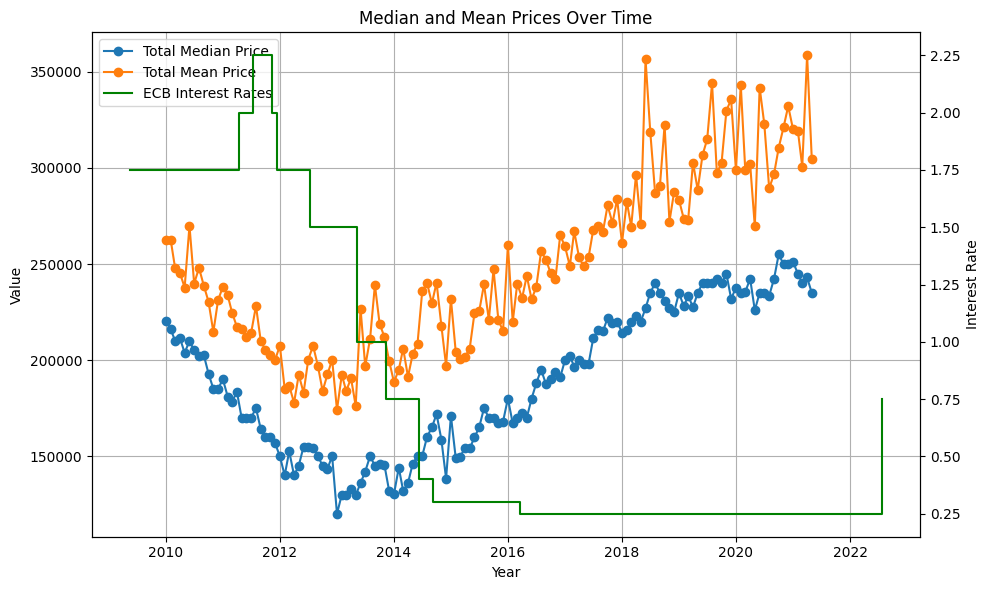

In [344]:
# Create a line plot of median monthly prices, mean monthly prices and monthly interest rates
plt.figure(figsize=(10, 6))
plt.plot(monthly_stats_df['month_year_timestamp'], monthly_stats_df['total_median_price'], marker='o', label='Total Median Price')
plt.plot(monthly_stats_df['month_year_timestamp'], monthly_stats_df['total_mean_price'], marker='o', label='Total Mean Price')
plt.title('Median and Mean Prices Over Time')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()

ax1 = plt.gca()  # Get the current axes
ax2 = ax1.twinx()  # Create a twin axes sharing the x-axis
ax2.step(df_interest_rate['DATE_INTEREST_RATE'], df_interest_rate['ECB_INTEREST_RATE'], color='green', where='pre', label='ECB Interest Rates')
ax2.set_ylabel('Interest Rate')

# Combine legends from both plots
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

In [345]:
# Sort DataFrames by date columns
df_house.sort_values(by='SALE_DATE', inplace=True)
df_interest_rate.sort_values(by='DATE_INTEREST_RATE', inplace=True)

# Forward fill missing values in interest rate DataFrame
df_interest_rate['ECB_INTEREST_RATE'].ffill(inplace=True)

# Merge DataFrames
merged_df = pd.merge_asof(df_house, df_interest_rate, left_on='SALE_DATE', right_on='DATE_INTEREST_RATE', direction='backward')

# Drop unnecessary columns
merged_df.drop(columns='DATE_INTEREST_RATE', inplace=True)

# Fill forward the ECB_INTEREST_RATE column in the merged DataFrame
merged_df['ECB_INTEREST_RATE'].ffill(inplace=True)

# Display the updated DataFrame
merged_df.head()

,SALE_DATE,ADDRESS,POSTAL_CODE,COUNTY,SALE_PRICE,IF_MARKET_PRICE,IF_VAT_EXCLUDED,PROPERTY_DESC,PROPERTY_SIZE_DESC,month_year_x,ECB_INTEREST_RATE,month_year_y
0,2010-01-01,"5 Braemor Drive, Churchtown, Co.Dublin",NaN,Dublin,343000.0,0,0,Second-Hand Dwelling house /Apartment,NaN,2010-01,1.75,2009-05
1,2010-01-03,"134 Ashewood Walk, Summerhill Lane, Portlaoise",NaN,Laois,185000.0,0,1,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...,2010-01,1.75,2009-05
2,2010-01-04,"59 ormond keep, nenagh",NaN,Tipperary,128000.0,0,0,Second-Hand Dwelling house /Apartment,NaN,2010-01,1.75,2009-05
3,2010-01-04,"66 Rory O'Connor Place, Arklow",NaN,Wicklow,145000.0,0,0,Second-Hand Dwelling house /Apartment,NaN,2010-01,1.75,2009-05
4,2010-01-04,"78 Sundays Well Road, Cork",NaN,Cork,510000.0,0,0,Second-Hand Dwelling house /Apartment,NaN,2010-01,1.75,2009-05


In [346]:
# Drop unnecessary columns
columns_to_drop = ['POSTAL_CODE', 'IF_MARKET_PRICE','IF_VAT_EXCLUDED','PROPERTY_SIZE_DESC','month_year_y']
merged_df.drop(columns=columns_to_drop, inplace=True)

In [347]:
# Creating new column with year
merged_df['year'] = df_house['SALE_DATE'].dt.year

In [348]:
# Checking unique values for county and description
print(merged_df['COUNTY'].unique())
print(merged_df['PROPERTY_DESC'].unique())

['Dublin' 'Laois' 'Tipperary' 'Wicklow' 'Cork' 'Wexford' 'Mayo'
 'Roscommon' 'Donegal' 'Longford' 'Limerick' 'Galway' 'Cavan' 'Meath'
 'Carlow' 'Clare' 'Kilkenny' 'Sligo' 'Waterford' 'Offaly' 'Kildare'
 'Louth' 'Kerry' 'Westmeath' 'Monaghan' 'Leitrim']
['Second-Hand Dwelling house /Apartment' 'New Dwelling house /Apartment'
 'Teach/�ras�n C�naithe Ath�imhe' 'Teach/�ras�n C�naithe Nua'
 'Teach/?ras?n C?naithe Nua']


In [349]:
# Define the replacement values and corresponding unique values to be replaced
replacement_mapping = {
    'Second-Hand Dwelling house /Apartment': 'Second Hand',
    'Teach/�ras�n C�naithe Ath�imhe': 'Second Hand',
    'New Dwelling house /Apartment': 'New',
    'Teach/�ras�n C�naithe Nua': 'New',
    'Teach/?ras?n C?naithe Nua': 'New'}

# Replace values in the 'PROPERTY_DESC' column using the mapping
merged_df['PROPERTY_DESC'] = merged_df['PROPERTY_DESC'].replace(replacement_mapping)
print(merged_df['PROPERTY_DESC'].unique())

['Second Hand' 'New']


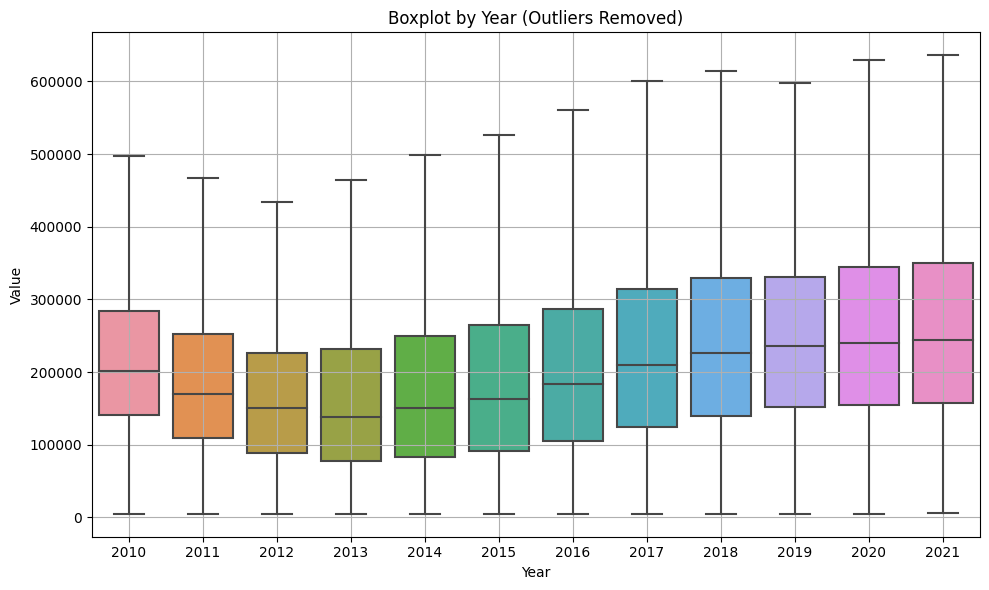

In [350]:
# Create a boxplot with outliers removed
plt.figure(figsize=(10, 6))
sns.boxplot(x='year', y='SALE_PRICE', data=merged_df, showfliers=False)
plt.title('Boxplot by Year (Outliers Removed)')
plt.xlabel('Year')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

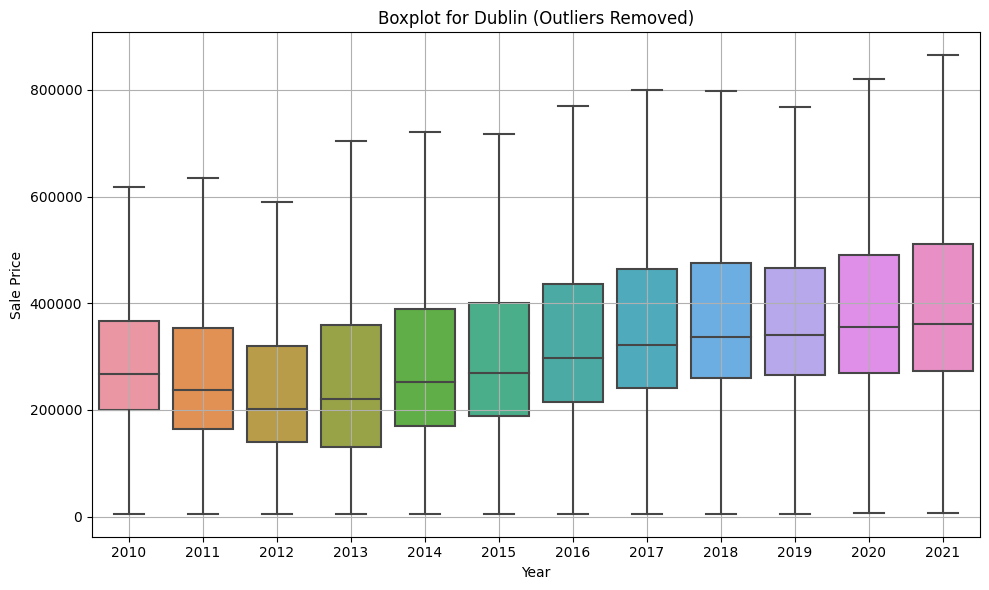

In [351]:
# Defining a function to create a boxplot for any county provided
def county_boxplot(county_name):
    county_data = merged_df[merged_df['COUNTY'] == county_name]

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='year', y='SALE_PRICE', data=county_data, showfliers=False)
    plt.title(f'Boxplot for {county_name} (Outliers Removed)')
    plt.xlabel('Year')
    plt.ylabel('Sale Price')
    plt.grid(True)
    plt.tight_layout()

    plt.show()

# Call the function with a specific county name
county_boxplot('Dublin')

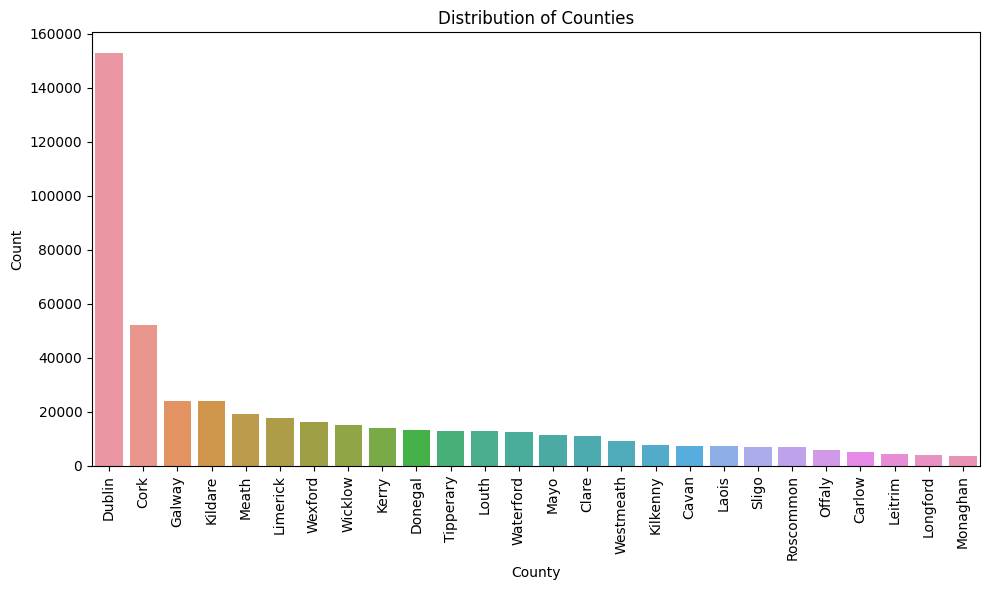

In [352]:
# Sort the data by the count of each category
sorted_df = merged_df['COUNTY'].value_counts().reset_index()
sorted_df.columns = ['COUNTY', 'COUNT']

# Create the histogram plot
plt.figure(figsize=(10, 6))  # Set the figure size
sns.barplot(data=sorted_df, x='COUNTY', y='COUNT')
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.xlabel('County')
plt.ylabel('Count')
plt.title('Distribution of Counties')
plt.tight_layout()  # Adjust layout for better appearance
plt.show()

<ipython-input-353-f89a2f990796>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(merged_df.corr(),annot = True)


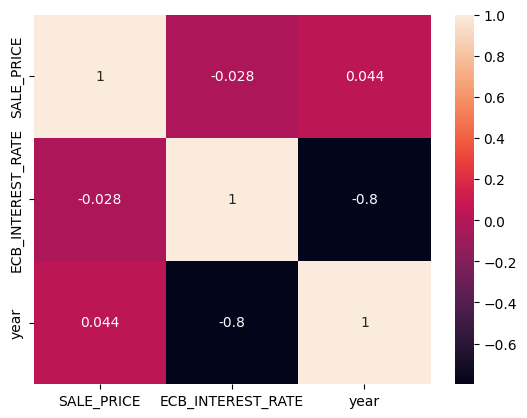

In [353]:
# Creating a heatmap for correlation
sns.heatmap(merged_df.corr(),annot = True)
plt.show()

In [354]:
# Creating a new dataframe of interest rates for all months from 2009 to 2022
start_date = pd.to_datetime('2009-04-14')
end_date = pd.to_datetime('2022-08-01')

# Generate a list of all months between start_date and end_date
date_range = pd.date_range(start_date, end_date, freq='MS')

# Convert the date_range to a DataFrame with a 'month_year' column
df_month_year = pd.DataFrame({'month_year': date_range})

# Convert 'month_year' to string to match the format in df_interest_rate
df_month_year['month_year'] = df_month_year['month_year'].dt.strftime('%Y-%m')

# Merge the new DataFrame with the existing df_interest_rate DataFrame based on 'month_year'
df_interest_rate = pd.merge(df_interest_rate, df_month_year, left_on=df_interest_rate['DATE_INTEREST_RATE'].dt.strftime('%Y-%m'), right_on='month_year', how='right')

# Drop the extra columns introduced by the merge
df_interest_rate.drop(columns=['month_year_y'], inplace=True)
df_interest_rate.drop(columns=['month_year_x'], inplace=True)
df_interest_rate.drop(columns=['DATE_INTEREST_RATE'], inplace=True)

df_interest_rate['ECB_INTEREST_RATE'] = df_interest_rate['ECB_INTEREST_RATE'].fillna(method='ffill')

# Print the updated DataFrame
print(df_interest_rate)

    month_year  ECB_INTEREST_RATE
0      2009-05               1.75
1      2009-06               1.75
2      2009-07               1.75
3      2009-08               1.75
4      2009-09               1.75
..         ...                ...
155    2022-04               0.25
156    2022-05               0.25
157    2022-06               0.25
158    2022-07               0.75
159    2022-08               0.75

[160 rows x 2 columns]


In [355]:
# Convert to datatime format
df_interest_rate['month_year_timestamp'] = df_interest_rate['month_year'].astype(str)
df_interest_rate['month_year_timestamp'] = pd.to_datetime(df_interest_rate['month_year_timestamp'])

df_interest_rate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160 entries, 0 to 159
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   month_year            160 non-null    object        
 1   ECB_INTEREST_RATE     160 non-null    float64       
 2   month_year_timestamp  160 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 5.0+ KB


In [356]:
# Merge monthly interest rates with the monthly house rice stats
merged_monthly_interest_df = pd.merge(df_interest_rate, monthly_stats_df,on='month_year_timestamp', how='right')

In [357]:
# Drop the extra columns introduced by the merge
merged_monthly_interest_df = merged_monthly_interest_df.drop(columns=['month_year_x','month_year_y'], axis=1)

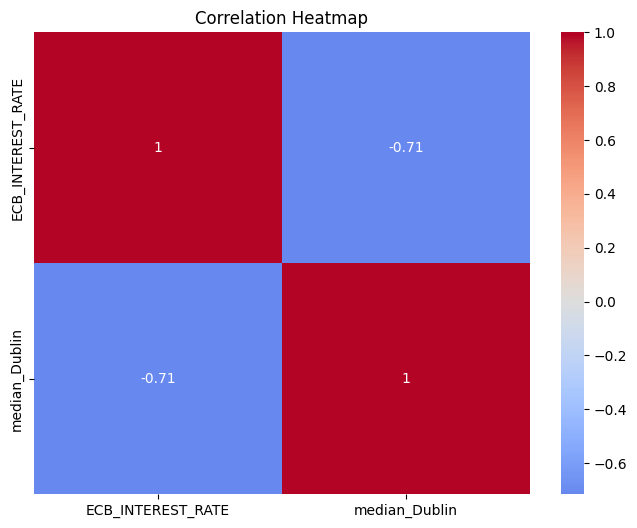

In [358]:
# Defining a function to plot a heatmap of correlation between ECB rates and county median house prices
def calculate_and_plot_corr(data_df, median_col):
    # Calculate correlation matrix
    correlation_matrix = data_df[['ECB_INTEREST_RATE', median_col]].corr()

    # Create a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap')
    plt.show()
calculate_and_plot_corr(merged_monthly_interest_df,'median_Dublin')

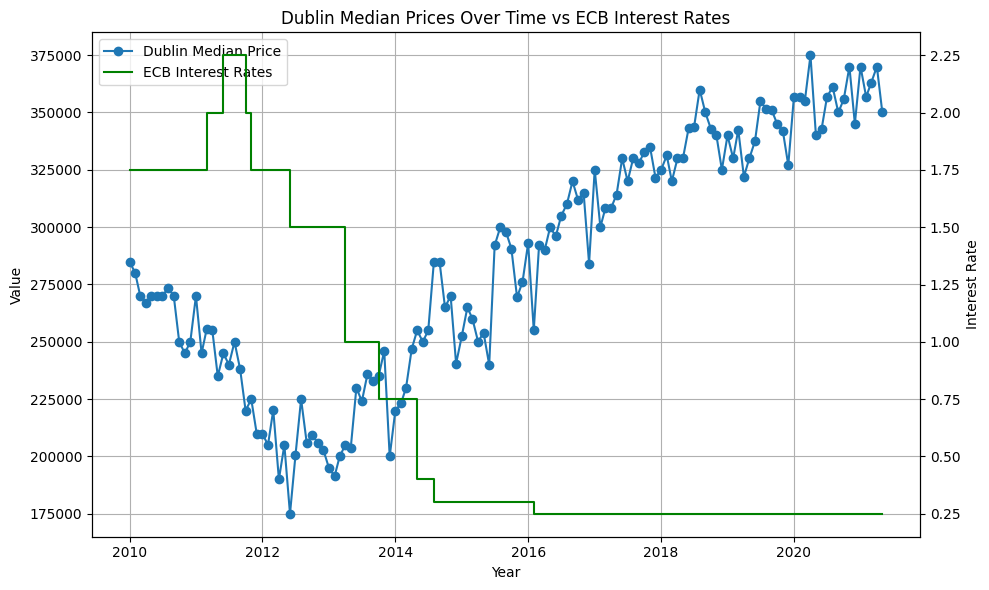

In [359]:
# Create a line plot of Dublin Median House prices vs ECB Interest Rates
plt.figure(figsize=(10, 6))
plt.plot(merged_monthly_interest_df['month_year_timestamp'], merged_monthly_interest_df['median_Dublin'], marker='o', label='Dublin Median Price')
plt.title('Dublin Median Prices Over Time vs ECB Interest Rates')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Create a secondary y-axis for the second plot
ax1 = plt.gca()  # Get the current axes
ax2 = ax1.twinx()  # Create a twin axes sharing the x-axis
ax2.step(merged_monthly_interest_df['month_year_timestamp'], merged_monthly_interest_df['ECB_INTEREST_RATE'], color='green', where='pre', label='ECB Interest Rates')
ax2.set_ylabel('Interest Rate')

# Combine legends from both plots
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

Slope: -55562.119352059875
Intercept: 327117.20649306144


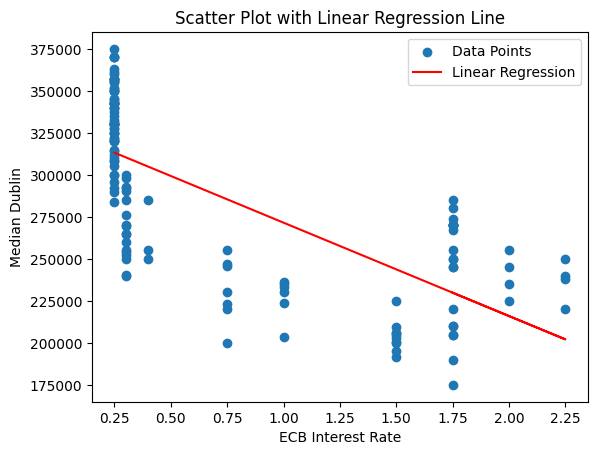

In [360]:
# Calculating slope and intercept for a line of best fit
slope ,intercept = np.polyfit(merged_monthly_interest_df['ECB_INTEREST_RATE'], merged_monthly_interest_df['median_Dublin'],1)
print("Slope:", slope)
print("Intercept:", intercept)

# Scatter plot of median dublin house prices vs ECB Interest Rates
plt.scatter(merged_monthly_interest_df['ECB_INTEREST_RATE'], merged_monthly_interest_df['median_Dublin'], label='Data Points')

# Linear regression line
x_values = np.array(merged_monthly_interest_df['ECB_INTEREST_RATE'])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, color='red', label='Linear Regression')

# Labels and legend
plt.xlabel('ECB Interest Rate')
plt.ylabel('Median Dublin House Prices')
plt.title('Scatter Plot with Linear Regression Line')
plt.legend()

# Display the plot
plt.show()

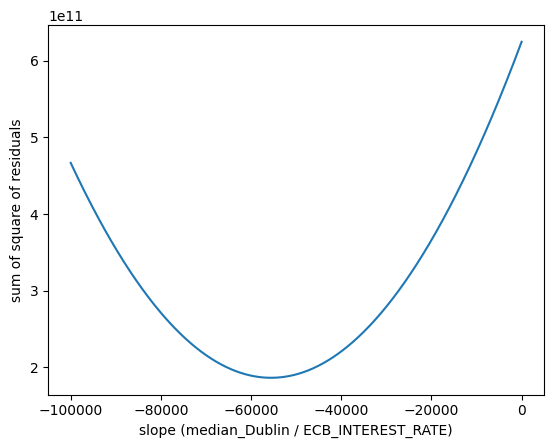

In [361]:
# Specify slopes to consider: a_vals
a_vals = np.linspace(0, 100000, 1000)*-1
b = intercept
# Initialize sum of square of residuals: rss
rss = np.empty_like(a_vals)

# Compute sum of square of residuals for each value of a_vals
for i, a in enumerate(a_vals):
    rss[i] = np.sum((merged_monthly_interest_df['median_Dublin'] - a*merged_monthly_interest_df['ECB_INTEREST_RATE'] - b)**2)

# Plot the RSS
plt.plot(a_vals, rss, '-')
plt.xlabel('slope (median_Dublin / ECB_INTEREST_RATE)')
plt.ylabel('sum of square of residuals')

plt.show()

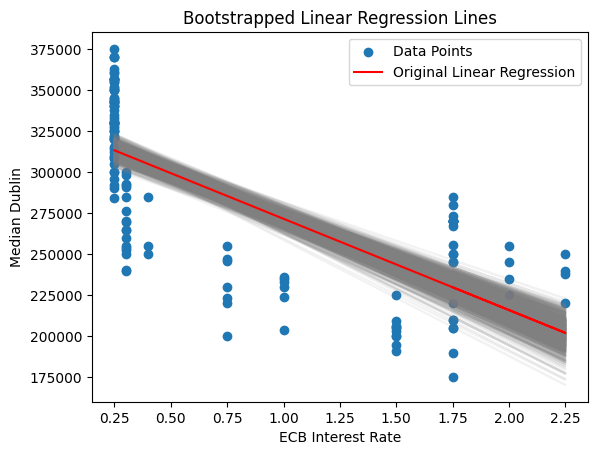

Slope Confidence Interval: [-65219.10558698 -47402.97165083]
Intercept Confidence Interval: [318329.36565811 335863.29535213]


In [362]:
# Number of bootstraps
num_bootstraps = 1000

# Initialize lists to store bootstrapped coefficients
bootstrapped_slopes = []
bootstrapped_intercepts = []

# Bootstrapping process
for _ in range(num_bootstraps):
    # Resample the data with replacement
    sampled_data = merged_monthly_interest_df.sample(frac=1, replace=True)

    # Fit linear regression model to resampled data
    slope, intercept = np.polyfit(sampled_data['ECB_INTEREST_RATE'], sampled_data['median_Dublin'], 1)

    # Store the coefficients
    bootstrapped_slopes.append(slope)
    bootstrapped_intercepts.append(intercept)

# Calculate confidence intervals
slope_ci = np.percentile(bootstrapped_slopes, [2.5, 97.5])
intercept_ci = np.percentile(bootstrapped_intercepts, [2.5, 97.5])

# Original linear regression model
slope, intercept = np.polyfit(merged_monthly_interest_df['ECB_INTEREST_RATE'], merged_monthly_interest_df['median_Dublin'], 1)

# Scatter plot
plt.scatter(merged_monthly_interest_df['ECB_INTEREST_RATE'], merged_monthly_interest_df['median_Dublin'], label='Data Points')

# Bootstrapped linear regression lines
x_values = np.array(merged_monthly_interest_df['ECB_INTEREST_RATE'])
for i in range(num_bootstraps):
    y_values = bootstrapped_slopes[i] * x_values + bootstrapped_intercepts[i]
    plt.plot(x_values, y_values, color='gray', alpha=0.1)

# Original linear regression line
y_values_original = slope * x_values + intercept
plt.plot(x_values, y_values_original, color='red', label='Original Linear Regression')

# Labels and legend
plt.xlabel('ECB Interest Rate')
plt.ylabel('Median Dublin')
plt.title('Bootstrapped Linear Regression Lines')
plt.legend()

# Display the plot
plt.show()

# Print confidence intervals
print("Slope Confidence Interval:", slope_ci)
print("Intercept Confidence Interval:", intercept_ci)

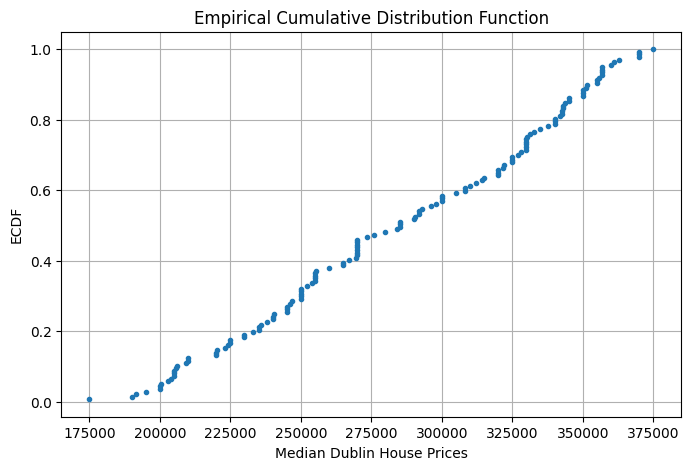

In [363]:
# Calculate ECDF
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(data) + 1) / len(data)
    return x, y

x, y = ecdf(merged_monthly_interest_df['median_Dublin'])

# Plot ECDF
plt.figure(figsize=(8, 5))
plt.plot(x, y, marker='.', linestyle='none')
plt.xlabel('Median Dublin House Prices')
plt.ylabel('ECDF')
plt.title('Empirical Cumulative Distribution Function')
plt.grid(True)
plt.show()

In [364]:
x = merged_monthly_interest_df['ECB_INTEREST_RATE']
y = merged_monthly_interest_df['median_Dublin']

# Null Hypothesis (H0): There is no significant linear correlation between ECB_INTEREST_RATE & median_Dublin.
# Alternative Hypothesis (H1): There is a significant linear correlation between ECB_INTEREST_RATE & median_Dublin.
# Calculate the sample correlation coefficient
r, _ = stats.pearsonr(x, y)

# Sample size
n = len(x)

# Calculate the test statistic
t_stat = (r * np.sqrt(n - 2)) / np.sqrt(1 - r**2)

# Degrees of freedom
df = n - 2

# Calculate the two-tailed p-value
p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), df=df))

# Significance level
alpha = 0.05

# Compare p-value with alpha
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant linear correlation.")
else:
    print("Fail to reject the null hypothesis: There is no significant linear correlation.")


Reject the null hypothesis: There is a significant linear correlation.


(137, 1) (137,)


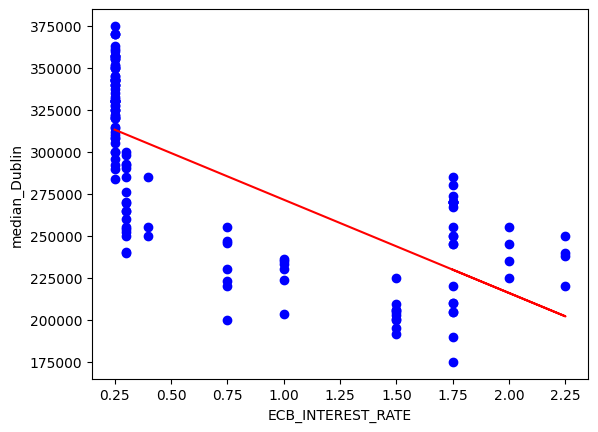

In [365]:
x = np.array(merged_monthly_interest_df['ECB_INTEREST_RATE'])
y = np.array(merged_monthly_interest_df['median_Dublin'])
# Reshape X
X = x.reshape(-1, 1)

# Check the shape of the features and targets
print(X.shape, y.shape)

# Import LinearRegression
from sklearn.linear_model import LinearRegression

# Create the model
reg = LinearRegression()

# Fit the model to the data
reg.fit(X,y)

# Make predictions
predictions = reg.predict(X)

# Create scatter plot
plt.scatter(X, y, color="blue")

# Create line plot
plt.plot(X, predictions, color="red")
plt.xlabel('ECB_INTEREST_RATE')
plt.ylabel('median_Dublin')

# Display the plot
plt.show()

In [366]:

X = merged_monthly_interest_df['ECB_INTEREST_RATE'].values
y = merged_monthly_interest_df['median_Dublin'].values
# Reshape X
X = X.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

# Instantiate the model
reg = LinearRegression()

# Fit the model to the data
reg.fit(X_train,y_train)

# Make predictions
y_pred = reg.predict(X_test)
print("Predictions: {}, Actual Values: {}".format(y_pred[:2], y_test[:2]))

Predictions: [225838.92598229 312234.91475532], Actual Values: [250000. 335000.]


In [367]:
# Compute R-squared
r_squared = reg.score(X_test, y_test)

# Compute RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Print the metrics
print("R^2: {}".format(r_squared))
print("RMSE: {}".format(rmse))

R^2: 0.5331644709874033
RMSE: 33277.62777111248


In [368]:
# Create a KFold object
kf = KFold(n_splits=6, shuffle=True, random_state=8)

reg = LinearRegression()

# Compute 6-fold cross-validation scores
cv_scores = cross_val_score(reg,X, y, cv=kf)

# Print scores
print("CV Scores: {}".format(cv_scores))

# Print the mean
print("Mean of CV Scores: {}".format(np.mean(cv_scores)))

# Print the standard deviation
print("STD of CV Scores: {}".format(np.std(cv_scores)))

# Print the 95% confidence interval
print("95% CI CV Scores: {}".format(np.quantile(cv_scores, [0.025, 0.975])))

CV Scores: [0.54807498 0.45454887 0.5544121  0.45073792 0.51730119 0.39048244]
Mean of CV Scores: 0.4859262500884463
STD of CV Scores: 0.05897661047758337
95% CI CV Scores: [0.39801437 0.55361996]


In [369]:
# Import Ridge
from sklearn.linear_model import Ridge
alphas = [0.01, 0.1, 1, 10.0, 100.0, 1000.0]
ridge_scores = []
for alpha in alphas:

  # Create a Ridge regression model
  ridge = Ridge(alpha=alpha)

  # Fit the data
  ridge.fit(X_train,y_train)

  # Obtain R-squared
  score = ridge.score(X_test, y_test)
  ridge_scores.append(score)
print(ridge_scores)

[0.5331992824455457, 0.5335082129431074, 0.5361829564925462, 0.5349399388328434, 0.2843606563730985, 0.021843048926795117]


In [370]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Set up the parameter grid
param_grid = {"alpha": np.linspace(0.00001, 1, 20)}

# Instantiate lasso_cv
ridge_cv = GridSearchCV(ridge, param_grid, cv=kf)

# Fit to the training data
ridge_cv.fit(X_train, y_train)
print("Tuned ridge paramaters: {}".format(ridge_cv.best_params_))
print("Tuned ridge score: {}".format(ridge_cv.best_score_))

Tuned ridge paramaters: {'alpha': 1.0}
Tuned ridge score: 0.3782415519471148


In [371]:
# Import DecisionTreeRegressor from sklearn.tree
from sklearn.tree import DecisionTreeRegressor

# Instantiate dt
dt = DecisionTreeRegressor(max_depth=4,
             min_samples_leaf=0.12,
            random_state=3)

# Fit dt to the training set
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4, min_samples_leaf=0.12, random_state=3)

In [372]:
# Import mean_squared_error from sklearn.metrics as MSE
from sklearn.metrics import mean_squared_error as MSE

# Compute y_pred
y_pred = dt.predict(X_test)

# Compute mse_dt
mse_dt = MSE(y_test, y_pred)

# Compute rmse_dt
rmse_dt = mse_dt**(1/2)

# Make predictions
print("Predictions: {}, Actual Values: {}".format(y_pred[:2], y_test[:2]))

# Print rmse_dt
print("Decision Tree RMSE: {:.2f}".format(rmse_dt))

Predictions: [244164.47368421 335762.89695122], Actual Values: [250000. 335000.]
Decision Tree RMSE: 18219.30


In [373]:
# Define params_dt
params_dt = {'max_depth':[2,4,6,8],'min_samples_leaf':[0.12,0.14,0.16,0.18]}

# Instantiate grid_dt
grid_dt = GridSearchCV(estimator=dt,
                       param_grid=params_dt,
                       scoring='neg_mean_squared_error',
                       cv=5,
                       n_jobs=-1)
# Fit the grid search object to the data
grid_dt.fit(X_train, y_train)

# Get the best hyperparameters and best estimator
best_params = grid_dt.best_params_
best_estimator = grid_dt.best_estimator_

print("Best Hyperparameters:", best_params)
print("Best Estimator:", best_estimator)

Best Hyperparameters: {'max_depth': 4, 'min_samples_leaf': 0.12}
Best Estimator: DecisionTreeRegressor(max_depth=4, min_samples_leaf=0.12, random_state=3)


In [374]:
# Fit dt to the training set
dt.fit(X_train, y_train)

# Predict the labels of the training set
y_pred_train = dt.predict(X_train)

# Evaluate the training set RMSE of dt
RMSE_train = (MSE(y_train, y_pred_train))**(1/2)

# Print RMSE_train
print('Train RMSE: {:.2f}'.format(RMSE_train))

Train RMSE: 23637.12


In [375]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score

# Assuming you have X_train, y_train, X_test, y_test properly defined

# Step 1: Data Preprocessing - Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Model Initialization and Training
k = 8  # Number of neighbors
knn = KNeighborsRegressor(n_neighbors=k)
knn.fit(X_train_scaled, y_train)

# Step 3: Predictions
y_pred = knn.predict(X_test_scaled)

# Step 4: Evaluate Model
rmse_knn = MSE(y_test, y_pred)**(1/2)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", rmse_knn)
print("R-squared:", r2)

Mean Squared Error: 19033.42877672963
R-squared: 0.847280939225251


In [376]:
# Define params_dt
params_knn = {'n_neighbors':[2,4,6,8]}

# Instantiate grid_dt
grid_dt = GridSearchCV(estimator=knn,
                       param_grid=params_knn,
                       scoring='neg_mean_squared_error',
                       cv=5,
                       n_jobs=-1)
# Fit the grid search object to the data
grid_dt.fit(X_train, y_train)

# Get the best hyperparameters and best estimator
best_params = grid_dt.best_params_
best_estimator = grid_dt.best_estimator_

print("Best Hyperparameters:", best_params)
print("Best Estimator:", best_estimator)

Best Hyperparameters: {'n_neighbors': 8}
Best Estimator: KNeighborsRegressor(n_neighbors=8)


In [377]:
# Define the list classifiers
classifiers = [('Linear Regression', reg), ('K Nearest Neighbours', knn), ('Classification Tree', dt)]

# Iterate over the pre-defined list of classifiers
for clf_name, clf in classifiers:

    # Fit clf to the training set
    clf.fit(X_train, y_train)

    # Predict y_pred
    y_pred = clf.predict(X_test)

    # Calculate RMSE
    rmse = MSE(y_test, y_pred)**(1/2)
    r2 = r2_score(y_test, y_pred)

    # Evaluate clf's accuracy on the test set
    print('{:s} : {:.3f}'.format(clf_name, rmse))
    print('{:s} : {:.3f}'.format(clf_name, r2))

Linear Regression : 33277.628
Linear Regression : 0.533
K Nearest Neighbours : 19033.429
K Nearest Neighbours : 0.847
Classification Tree : 18219.298
Classification Tree : 0.860


In [378]:
# Import VotingClassifier from sklearn.ensemble
from sklearn.ensemble import VotingRegressor

# Instantiate a VotingClassifier vc
vc = VotingRegressor(estimators=classifiers)

# Fit vc to the training set
vc.fit(X_train, y_train)

# Evaluate the test set predictions
y_pred = vc.predict(X_test)

# Calculate RMSE
rmse = MSE(y_test, y_pred)**(1/2)
r2 = r2_score(y_test, y_pred)

print('Voting Classifier: {:.3f}'.format(rmse))
print('Voting Classifier: {:.3f}'.format(r2))

Voting Classifier: 20099.888
Voting Classifier: 0.830


In [379]:
# Import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Instantiate gb
gb = GradientBoostingRegressor(n_estimators=200,
            max_depth=4,
            random_state=2)

# Fit gb to the training set
gb.fit(X_train,y_train)

# Predict test set labels
y_pred = gb.predict(X_test)

# Compute MSE
mse_test = MSE(y_test, y_pred)

# Compute RMSE
rmse_test = mse_test**(1/2)
r2 = r2_score(y_test, y_pred)

# Print RMSE
print('Test set RMSE of gb: {:.3f}'.format(rmse_test))
print('Test set R^2 of gb: {:.3f}'.format(r2))

Test set RMSE of gb: 19406.441
Test set R^2 of gb: 0.841


In [380]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=300, random_state=42)

# Fit the model to the training data
rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf.predict(X_test)

# Calculate Mean Squared Error
rmse = mean_squared_error(y_test, y_pred)**(1/2)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", rmse)
print('Test set R^2 of gb: {:.3f}'.format(r2))

Mean Squared Error: 18891.180540932055
Test set R^2 of gb: 0.850


In [381]:
# Define params_dt
params_rf = {'n_estimators':[100,200,300,400,500]}

# Instantiate grid_dt
grid_rf = GridSearchCV(estimator=rf,
                       param_grid=params_rf,
                       scoring='neg_mean_squared_error',
                       cv=5,
                       n_jobs=-1)
# Fit the grid search object to the data
grid_rf.fit(X_train, y_train)

# Get the best hyperparameters and best estimator
best_params = grid_rf.best_params_
best_estimator = grid_rf.best_estimator_

print("Best Hyperparameters:", best_params)
print("Best Estimator:", best_estimator)

Best Hyperparameters: {'n_estimators': 300}
Best Estimator: RandomForestRegressor(n_estimators=300, random_state=42)


In [382]:
X_test_2 = np.array([0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25]).reshape(-1, 1)

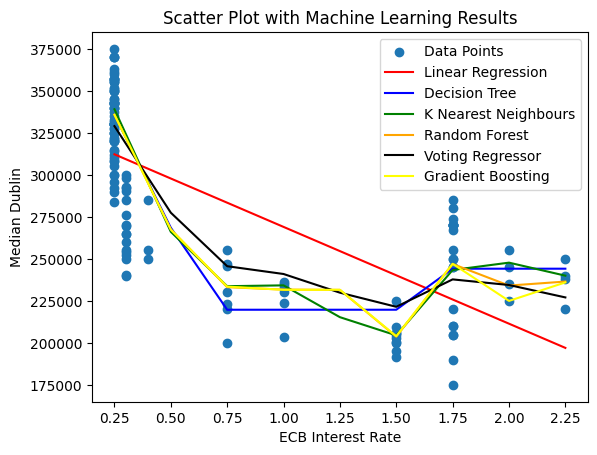

In [383]:
# Scatter plot
plt.scatter(merged_monthly_interest_df['ECB_INTEREST_RATE'], merged_monthly_interest_df['median_Dublin'], label='Data Points')

# Generate predictions using regressor models
predictions_model_1 = reg.predict(X_test_2)
predictions_model_2 = dt.predict(X_test_2)
predictions_model_3 = knn.predict(X_test_2)
predictions_model_4 = rf.predict(X_test_2)
predictions_model_5 = vc.predict(X_test_2)
predictions_model_6 = gb.predict(X_test_2)

# Plot regression lines
plt.plot(X_test_2, predictions_model_1, color='red', label='Linear Regression')
plt.plot(X_test_2, predictions_model_2, color='blue', label='Decision Tree')
plt.plot(X_test_2, predictions_model_3, color='green', label='K Nearest Neighbours')
plt.plot(X_test_2, predictions_model_4, color='orange', label='Random Forest')
plt.plot(X_test_2, predictions_model_5, color='black', label='Voting Regressor')
plt.plot(X_test_2, predictions_model_6, color='yellow', label='Gradient Boosting')


# Labels and legend
plt.xlabel('ECB Interest Rate')
plt.ylabel('Median Dublin')
plt.title('Scatter Plot with Machine Learning Results')
plt.legend()

# Display the plot
plt.show()

In [384]:
models = [("Linear Regression", reg),
    ("Random Forest", rf),
    ("Gradient Boosting", gb),
    ("Decision Tree", dt),
    ("K Nearest Neighbours", knn),
    ("Voting Regressor", vc)]

results = pd.DataFrame(columns=["Model", "RMSE", "R^2"])

for name, model in models:

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Calculate R^2
    r2 = r2_score(y_test, y_pred)

    # Append results to the DataFrame
    results = results.append({"Model": name, "RMSE": rmse, "R^2": r2}, ignore_index=True)
print(results)


<ipython-input-384-bc486f612f10>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model": name, "RMSE": rmse, "R^2": r2}, ignore_index=True)


                  Model          RMSE       R^2
0     Linear Regression  33277.627771  0.533164
1         Random Forest  18891.180541  0.849555
2     Gradient Boosting  19406.441155  0.841236
3         Decision Tree  18219.297992  0.860066
4  K Nearest Neighbours  19033.428777  0.847281
5      Voting Regressor  20099.888167  0.829688


<ipython-input-384-bc486f612f10>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model": name, "RMSE": rmse, "R^2": r2}, ignore_index=True)
<ipython-input-384-bc486f612f10>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model": name, "RMSE": rmse, "R^2": r2}, ignore_index=True)
<ipython-input-384-bc486f612f10>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model": name, "RMSE": rmse, "R^2": r2}, ignore_index=True)
<ipython-input-384-bc486f612f10>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model": name, "RMSE": rmse,